# Chemistry machine learning for drug discovery with DeepChem

This example uses machine learning to predict the lipophilicty of compounds.

[Lipophilicty](https://en.wikipedia.org/wiki/Lipophilicity) measures how well a compound dissolves in non-polar media such as fats and lipids. So it's important for drugs that are delivered orally (for example, via a pill) because the active ingredient [needs to be absorbed into the lipids](https://emerypharma.com/blog/drug-lipophilicity-and-absorption-a-continuous-challenge-toward-the-goal-of-drug-discovery/) of biological membranes.

_[Open this notebook in Google Colab](https://colab.research.google.com/drive/1pWK3h6en6rwnGHIDgbz6M5Yo1eDxy9Rr?usp=sharing)_

In [97]:
%%capture
!pip install --pre deepchem[tensorflow]

In [98]:
#For mol_frame
%%capture
!pip install git+https://github.com/apahl/mol_frame

from mol_frame import mol_frame as mf
import os, holoviews as hv
os.environ['HV_DOC_HTML'] = 'true'

In [99]:
import deepchem as dc
import seaborn
import pandas as pd
import matplotlib.pyplot as plt

[DeepChem](https://deepchem.io/) is a free and open-source Python package for deep learning for chemistry and other sciences. DeepChem has a [lipophilicty data set](https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html#lipo-datasets) contains measured [logD](https://www.cambridgemedchemconsulting.com/resources/physiochem/logD.html) values for 4200 compounds.

As usual for machine learning (ML), we split the data set into training and test data. We train the ML model on the train data, then apply it to the test data and check how well the model predicts the lipophilicty of compounds that the model hasn't processed before.

For this data set, we [split by scaffold](https://deepchem.readthedocs.io/en/latest/api_reference/splitters.html#scaffoldsplitter) the 4200 compounds based on the [Bemis-Murcko scaffold representation](https://pubs.acs.org/doi/10.1021/jm9602928). Such splitting groups molecules based on their scaffolds (core structure) to [prevent train and test from having very similar molecules](httphttps://github.com/deepchem/deepchem/blob/master/examples/tutorials/Working_With_Splitters.ipynb), which could lead to the model appearing to perform well on the test set, but then performing poorly on less-similar molecules in production.

In [100]:
tasks, datasets, transformers = dc.molnet.load_lipo(featurizer='GraphConv', splitter='Scaffold')
train_dataset, valid_dataset, test_dataset = datasets

The number of compounds in the train, validate, and test sets is:

In [101]:
splits = (train_dataset.X.shape[0], valid_dataset.X.shape[0], test_dataset.X.shape[0])
splits

(3360, 420, 420)

Which represents an 80:10:10 train:validate:test split:

In [102]:
[split / sum(splits) for split in splits]

[0.8, 0.1, 0.1]

Next, we build a model using DeepChem's [graph convolutional network](https://deepchem.readthedocs.io/en/latest/api_reference/models.html). We use the [dropout technique](https://ai-pool.com/a/s/dropout-in-deep-learning) to avoid overfitting.

In [103]:
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)

Then we train the model on the train dataset.

In [114]:
# Note that training with 100 epochs takes around 4 minutes on Google Colab.
# Before you finalize any code changes, you may want to set nb_epoch=10 to speed execution.
%%capture
model.fit(train_dataset, nb_epoch=100);

To check how well the model fits the train and test data, we examine the [Pearson correlation coefficient](https://www.scribbr.com/statistics/pearson-correlation-coefficient/) score.

In [115]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

Training set score: {'pearson_r2_score': 0.8259468138003999}
Test set score: {'pearson_r2_score': 0.452871200533043}


The [Pearson correlation coefficient](https://www.scribbr.com/statistics/pearson-correlation-coefficient/) score is worse for the test data than for the train data. This is expected because the test data is new to the model.

One contributing factor might be that our train set may not have molecules similar enough to those in the test set. Recall that we [split by scaffold](https://deepchem.readthedocs.io/en/latest/api_reference/splitters.html#scaffoldsplitter), so it's possible that such splitting led to compounds in the test set that have scaffolds significantly different from those in the train set.

Adding compounds to the dataset so that there is less "scaffold distance" (difference in scaffold structure) between groups of compounds might help. To take a simple hypothetical example, if we had a dataset with compounds containing fused rings, with many two-ring compounds and few four-ring compounds, scaffold splitting might put all the two-ring compounds in the train set and all the four-ring compounds in the test set. We expect that would lead to poor predictions on the test set. We would want to augment the dataset by adding compounds containing three fused rings.

To learn more about how well the model works, let's apply it to the test data and compare the predicted and experimental results.

In [116]:
lipos = model.predict_on_batch(test_dataset.X)

Then we make put the measured and model-predicted results into a [pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) for easy processing.

In [117]:
lipo_list = []
expt_lipo_list = []
for molecule, lipo, test_lipo in zip(test_dataset.ids, lipos, test_dataset.y):
    lipo_list += [lipo[0]]
    expt_lipo_list += [test_lipo[0]]
    
compound_id = list(range(len(test_dataset.ids)))
df = pd.DataFrame(list(zip(expt_lipo_list, lipo_list, test_dataset.ids, compound_id)), columns = ["measured", "predicted", "Smiles", "Compound_Id"])
df

measured  predicted  \
0   -1.810832  -0.733463   
1    0.319651  -0.555725   
2   -0.192325   0.204472   
3    0.938978   0.708903   
4    0.856401   0.135500   
..        ...        ...   
415  0.815112   1.078619   
416  1.327089  -0.286190   
417 -0.175810   0.295582   
418  0.071921  -1.197670   
419  0.806855   0.621466   

                                                                Smiles  \
0                 O[C@@H](CNCCCOCCNCCc1cccc(Cl)c1)c2ccc(O)c3NC(=O)Sc23   
1                                        NC1=NN(CC1)c2cccc(c2)C(F)(F)F   
2    COc1cc(ccc1Cn2ccc3ccc(cc23)C(=O)NCC4CCCC4)C(=O)NS(=O)(=O)c5ccccc5   
3                                NC(=O)NC(=O)C(Nc1ccc2CCCc2c1)c3ccccc3   
4                                         COc1ccc(cn1)c2ccc3nc(N)sc3c2   
..                                                                 ...   
415          COc1cc(ccc1N2CC[C@@H](O)C2)N3N=Nc4cc(sc4C3=O)c5ccc(Cl)cc5   
416                    CCC(COC(=O)c1cc(OC)c(OC)c(OC)c1)(N(C)C)c2ccccc2   
417                                   CCCSc1ncccc1C(=O)N2CCCC2c3ccncc3   
418                                            Oc1ncnc2scc(c3ccsc3)c12   
419                               OC1(CN2CCC1CC2)C#Cc3ccc(cc3)c4ccccc4   

     Compound_Id  
0              0  
1              1  
2              2  
3              3  
4              4  
..           ...  
415          415  
416          416  
417          417  
418          418  
419          419  

[420 rows x 4 columns]

Now we can use a scatter plot to compare the predicted against measured values. We use the [seaborn statistical data visualization package](https://seaborn.pydata.org/) to plot the data. We show the line where the predicted and measured lipophilicty values are equal, in other words the line that all points would lie on if the model made perfect predictions.

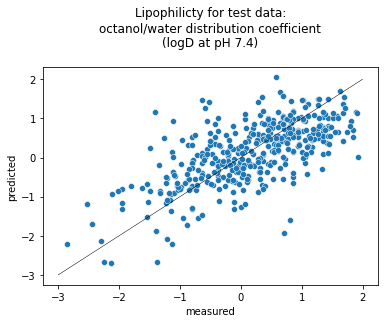

In [118]:
seaborn.scatterplot(data=df, x = "measured", y = "predicted").set(title='Lipophilicty for test data:\noctanol/water distribution coefficient\n(logD at pH 7.4)\n');
equal_line_x = [-3, 2]
equal_line_y = equal_line_x
plt.plot(equal_line_x, equal_line_y, color='k', linewidth=0.5);

We can also use [mol_frame](https://github.com/apahl/mol_frame) to make an interactive plot: If you mouse over a marker on the graph, the molecular structure will be displayed! (One interesting thing to note is that molecules which are close together on the plot may have very different molecular structures.) Also, you can pan and zoom the graph, and save it.

Unfortunately, the interactive plot is not working in the blog version of this notebook. Please visit the [Google Colab notebook](https://colab.research.google.com/drive/1pWK3h6en6rwnGHIDgbz6M5Yo1eDxy9Rr?usp=sharing) to access the interactive plot.

* using Smiles
* add b64:               (  420 |    5)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
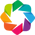

* using Mol_b64
* add img:               (  420 |    6)


:Scatter   [measured]   (predicted,Compound_Id,Image)
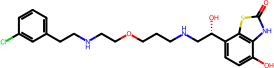
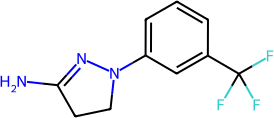
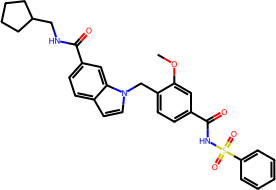
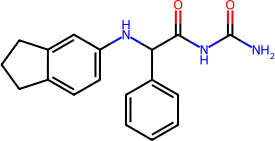
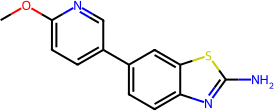
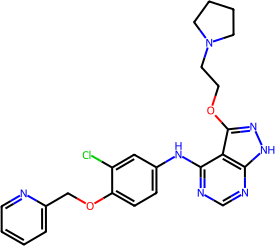
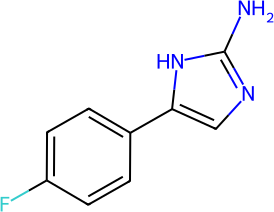
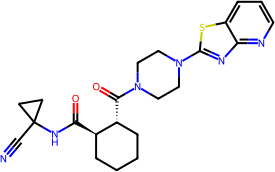
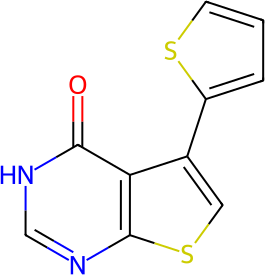
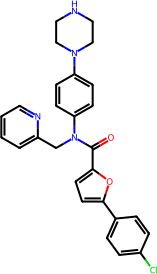
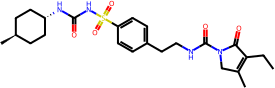
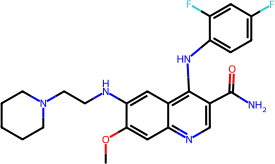
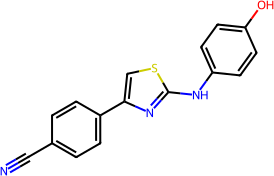
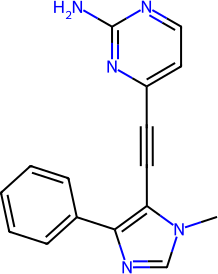
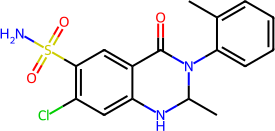
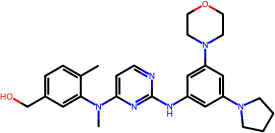
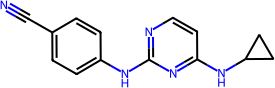
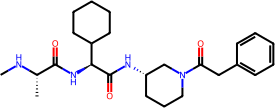
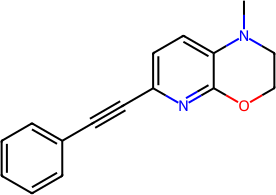
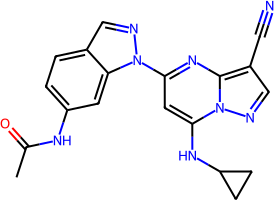
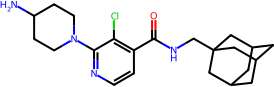
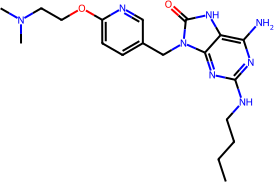
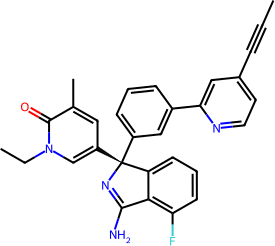
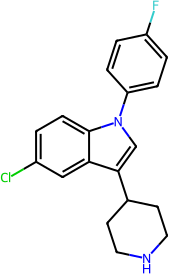
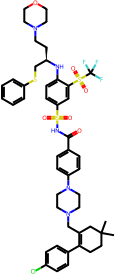
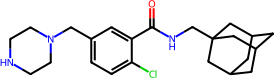
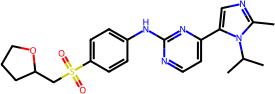
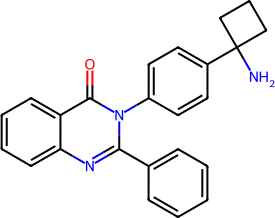
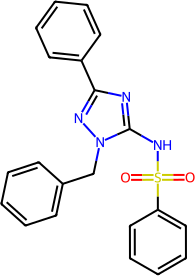
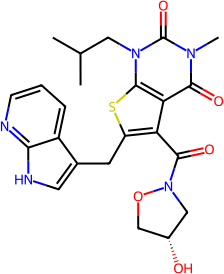
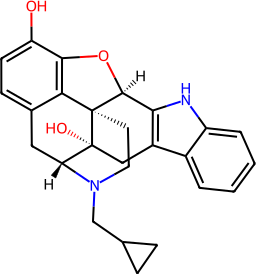
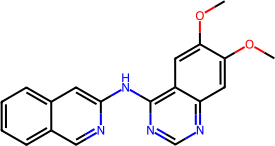
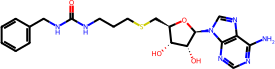
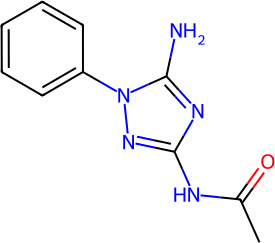
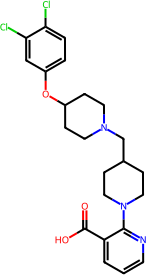
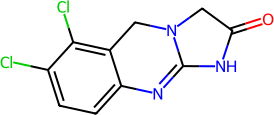
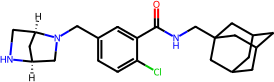
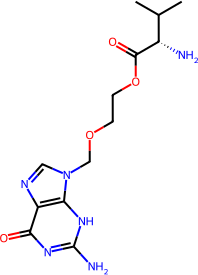
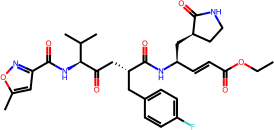
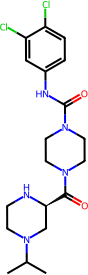
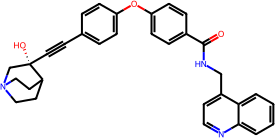
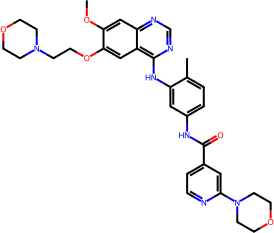
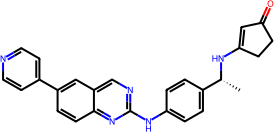
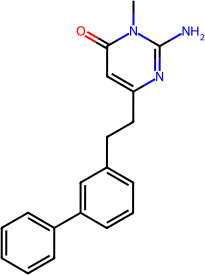
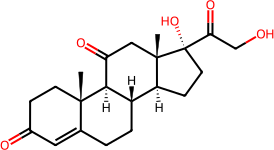
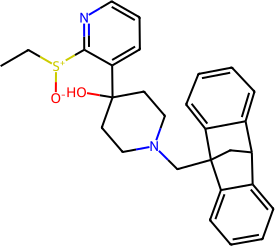
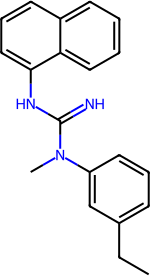
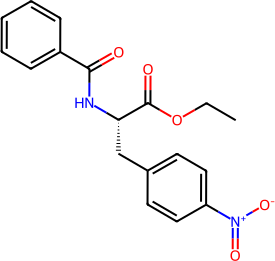
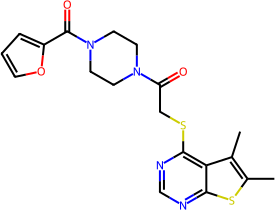
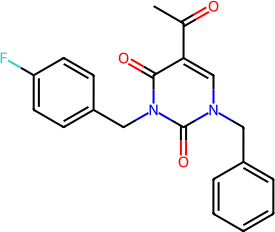
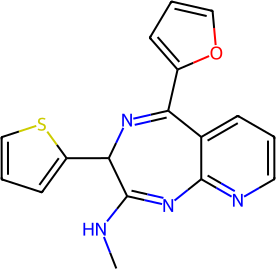
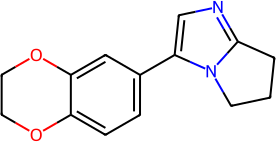
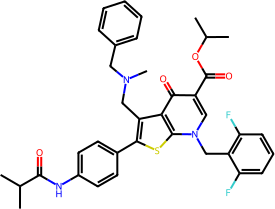
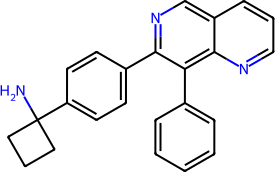
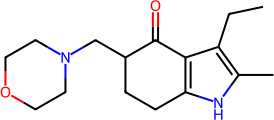
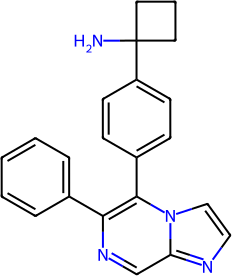
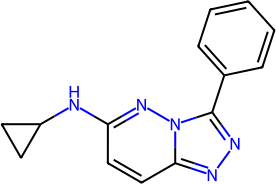
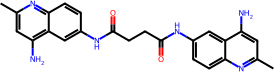
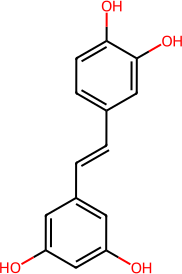
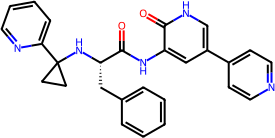
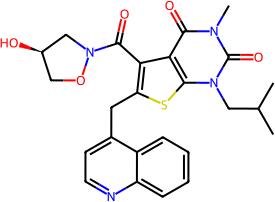
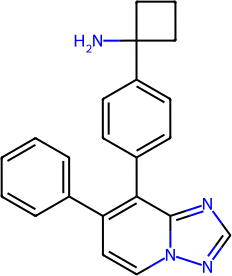
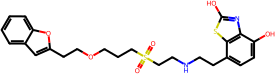
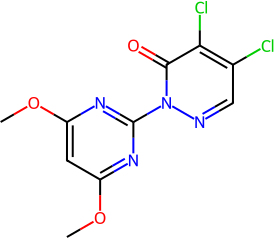
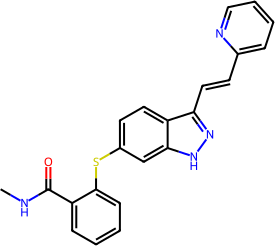
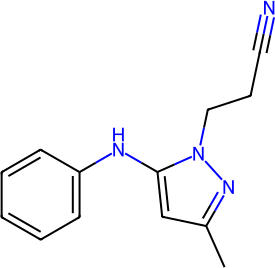
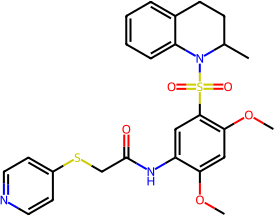
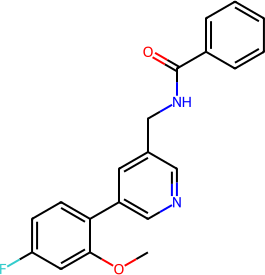
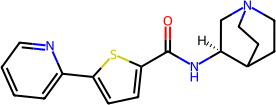
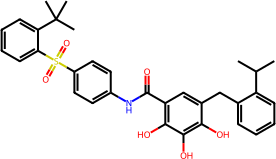
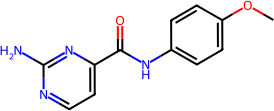
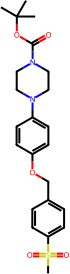
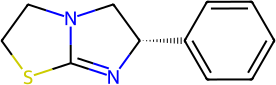
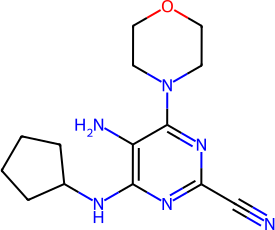
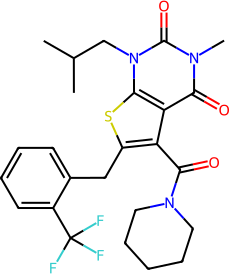
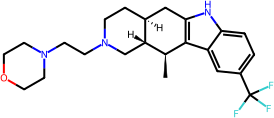
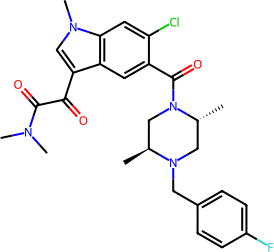
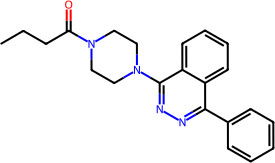
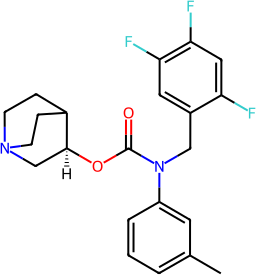
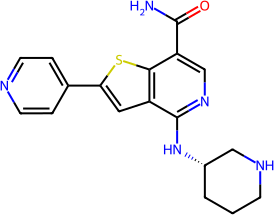
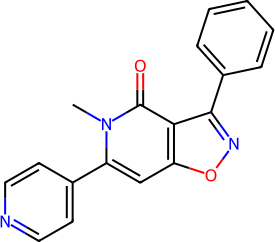
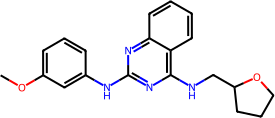
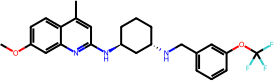
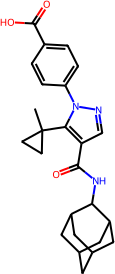
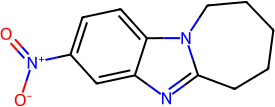
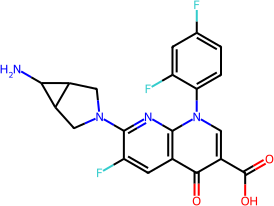
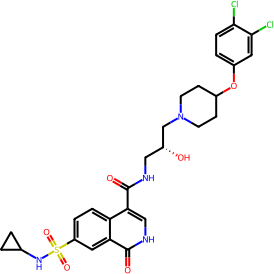
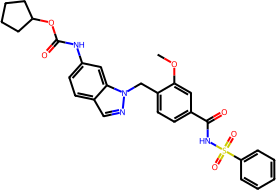
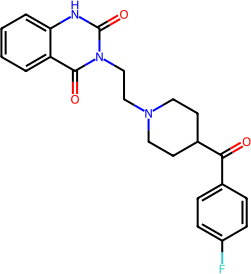
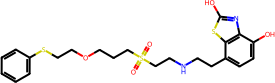
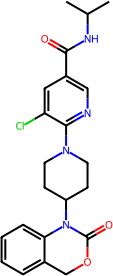
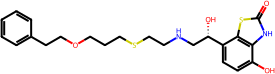
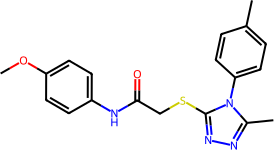
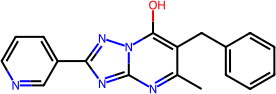
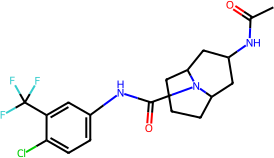
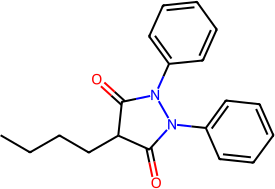
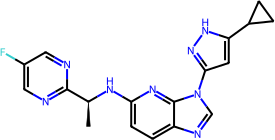
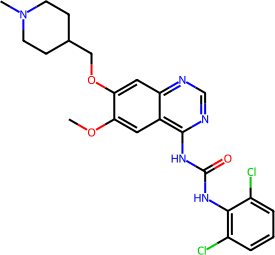
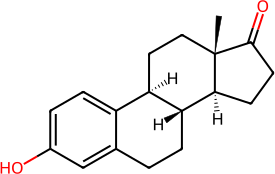
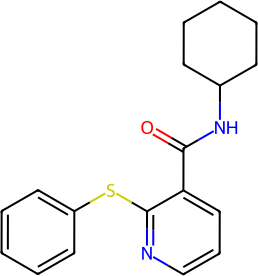
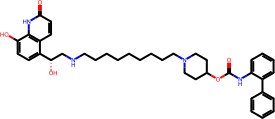
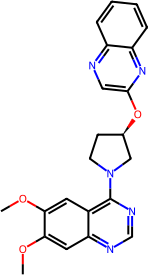
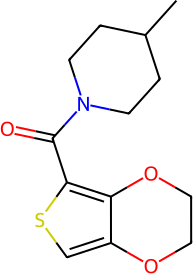
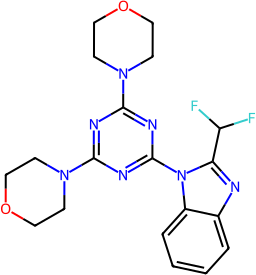
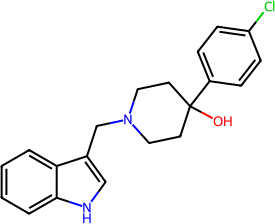
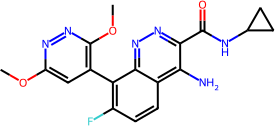
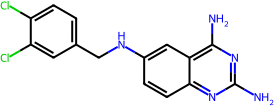
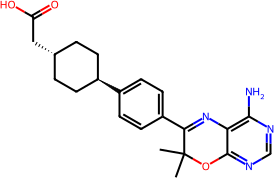
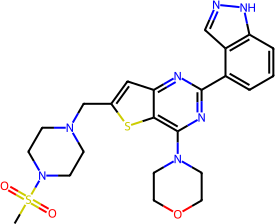
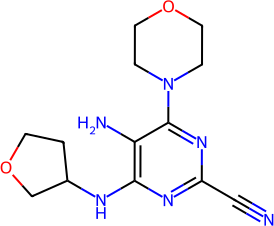
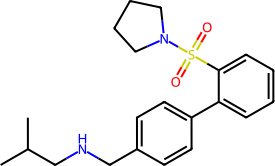
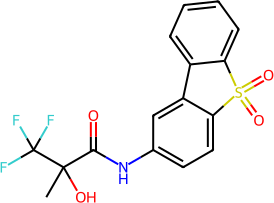
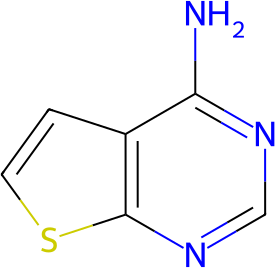
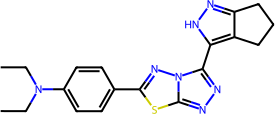
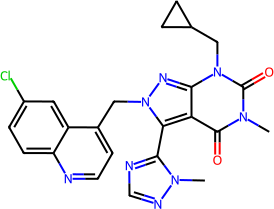
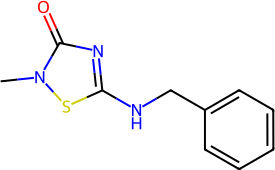
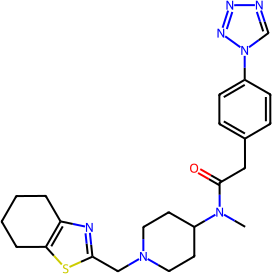
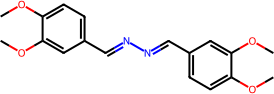
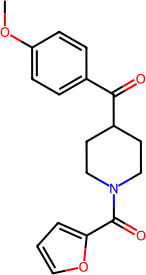
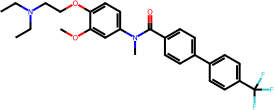
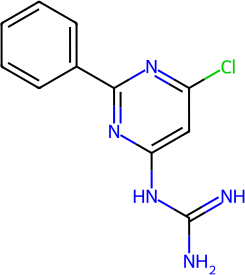
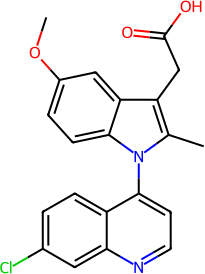
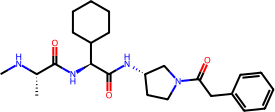
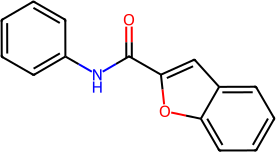
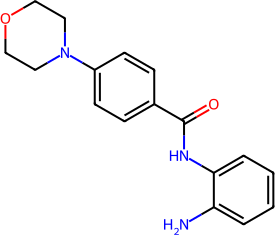
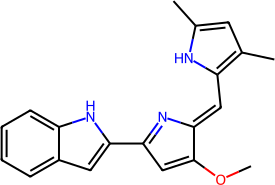
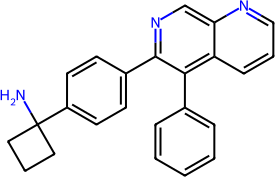
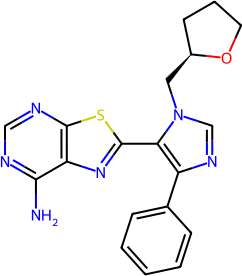
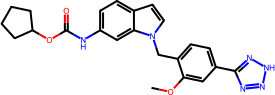
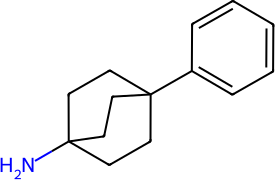
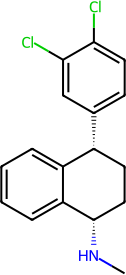
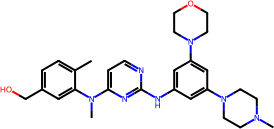
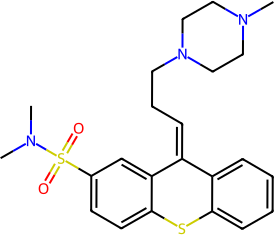
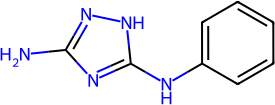
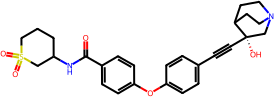
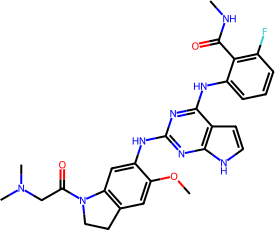
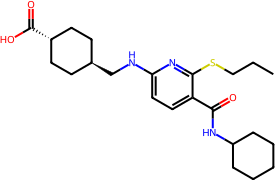
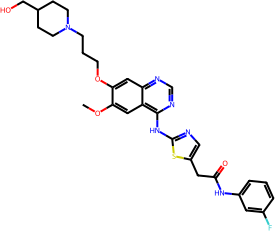
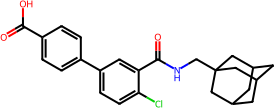
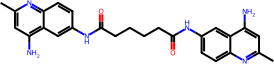
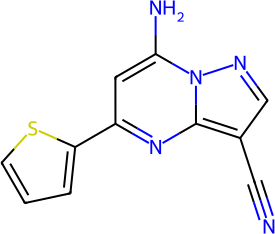
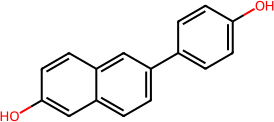
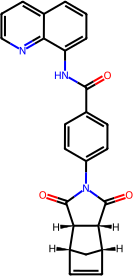
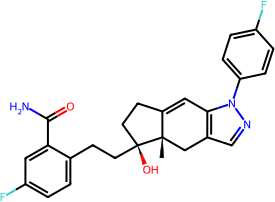
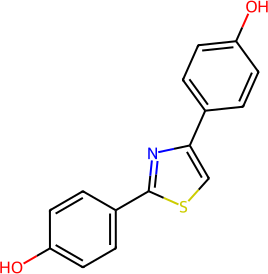
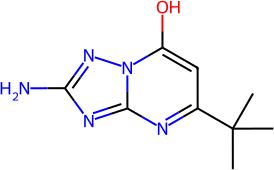
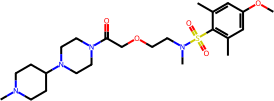
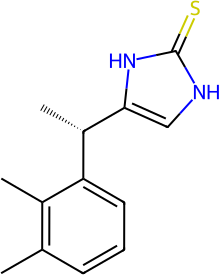
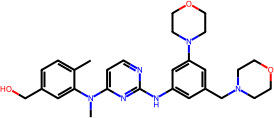
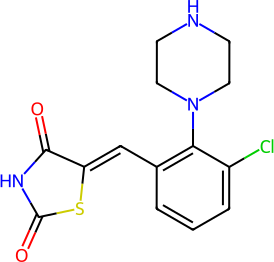
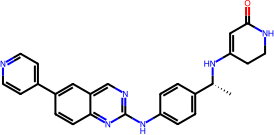
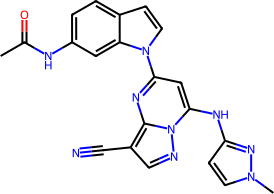
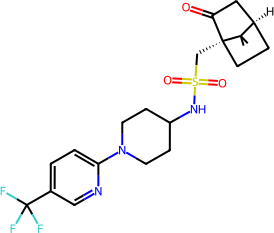
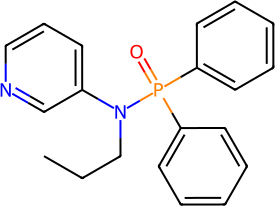
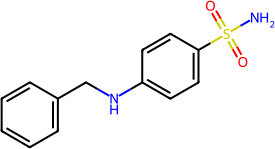
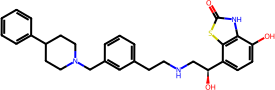
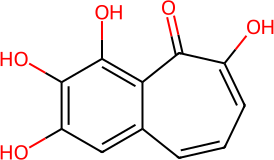
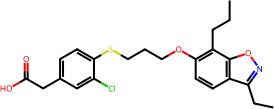
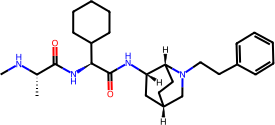
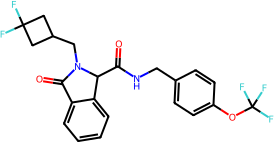
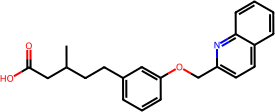
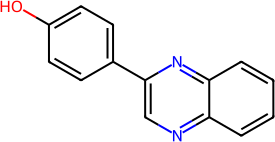
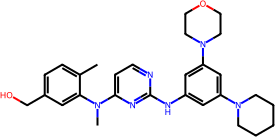
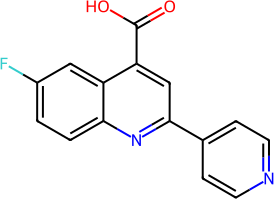
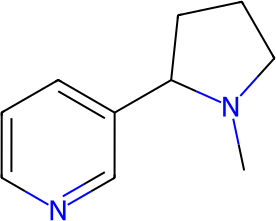
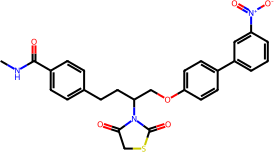
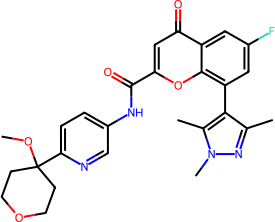
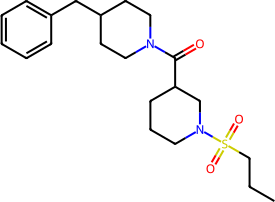
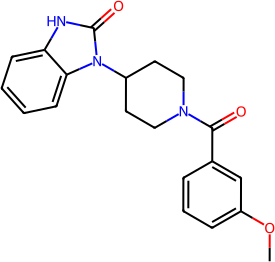
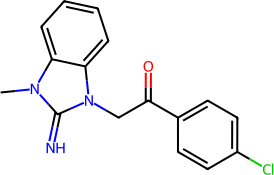
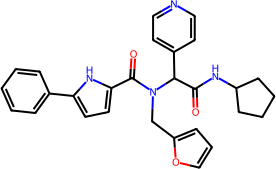
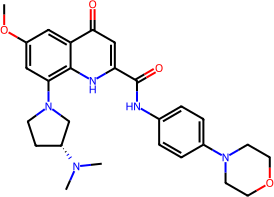
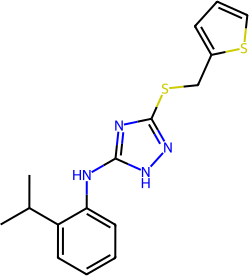
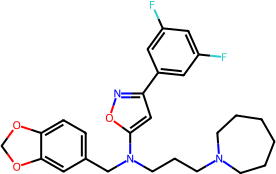
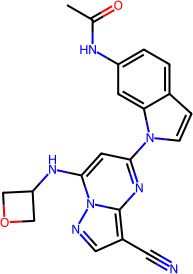
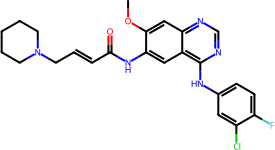
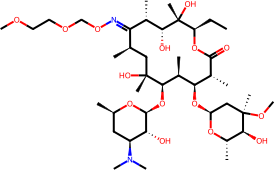
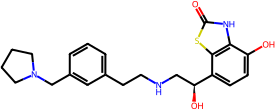
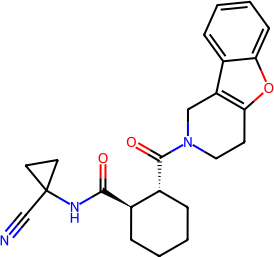
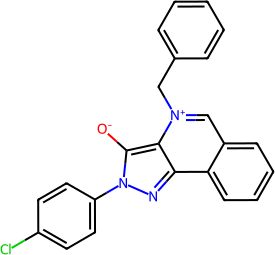
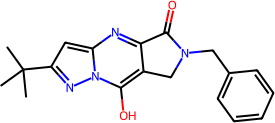
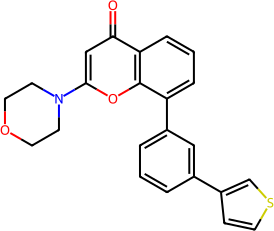
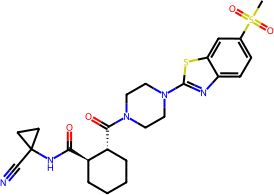
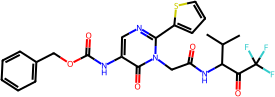
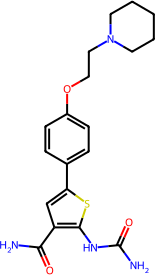
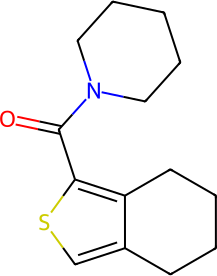
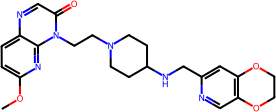
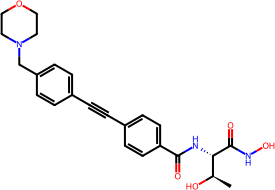
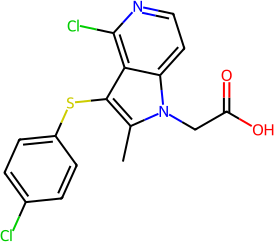
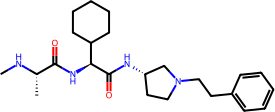
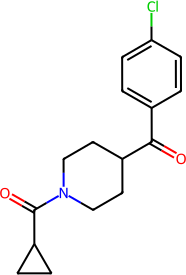
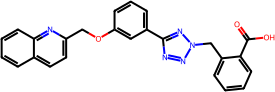
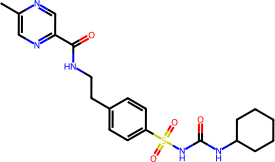
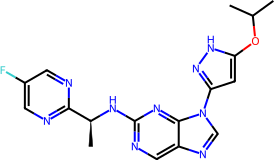
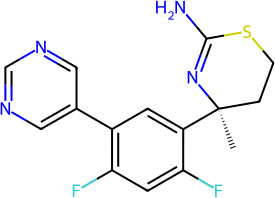
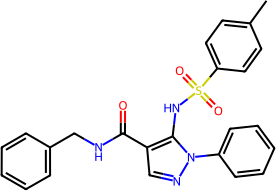
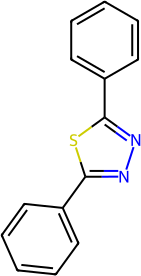
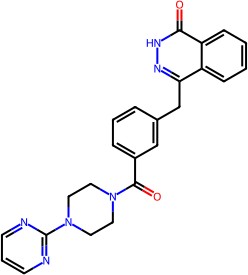
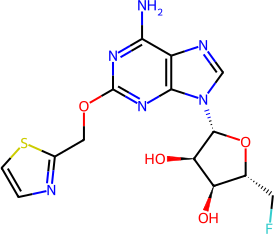
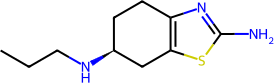
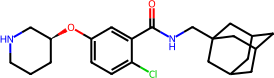
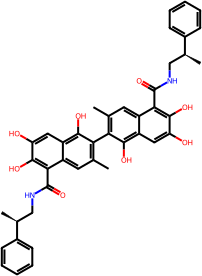
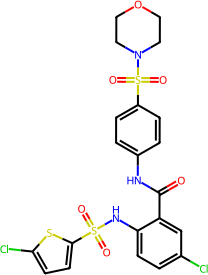
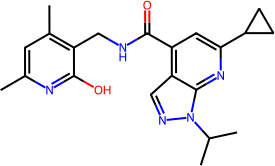
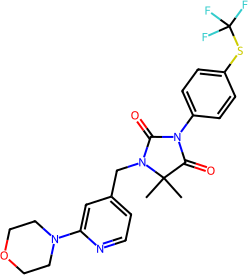
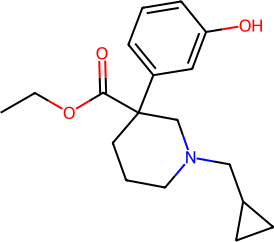
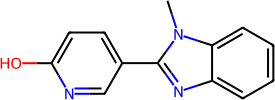
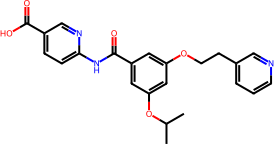
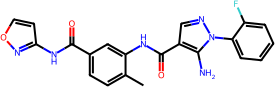
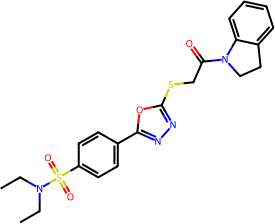
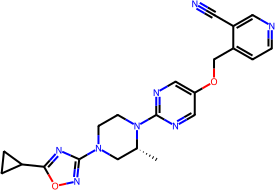
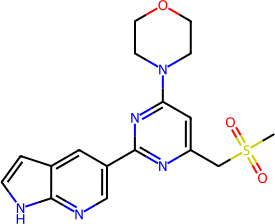
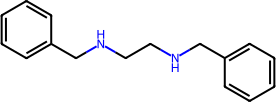
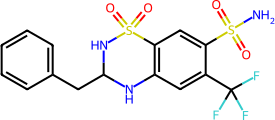
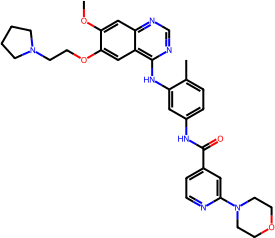
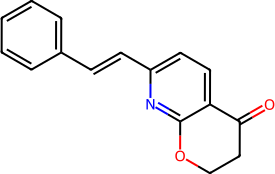
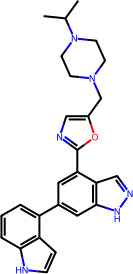
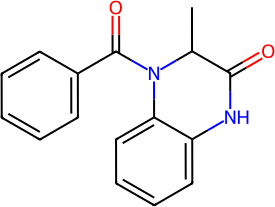
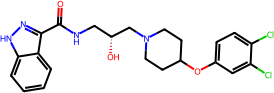
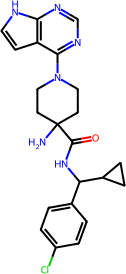
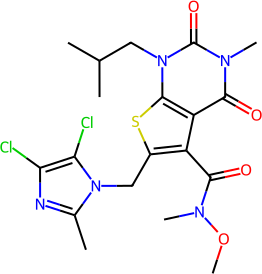
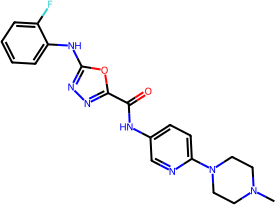
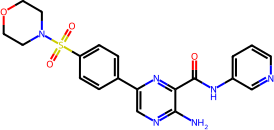
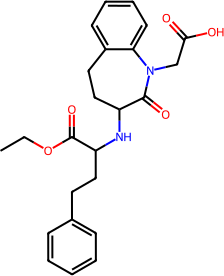
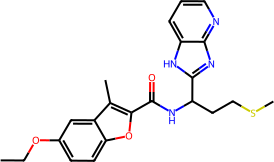
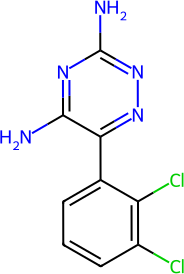
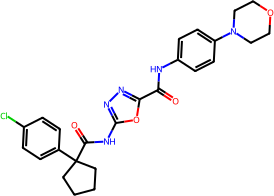
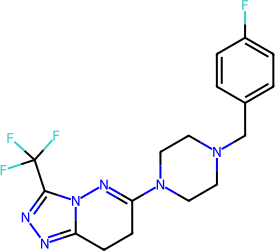
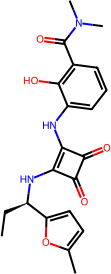
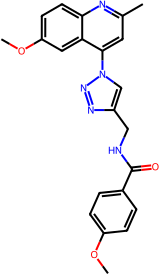
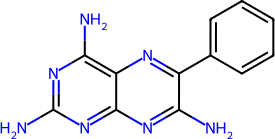
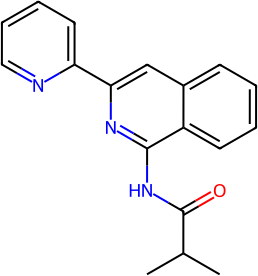
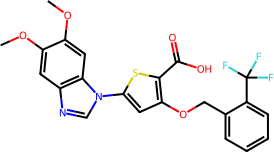
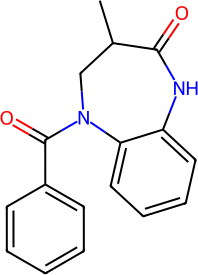
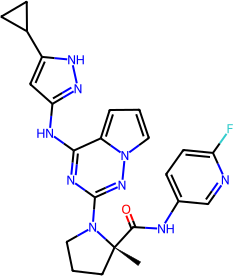
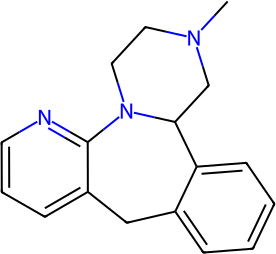
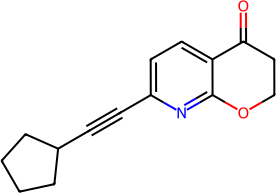
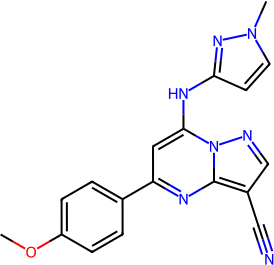
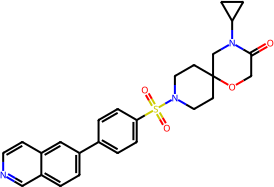
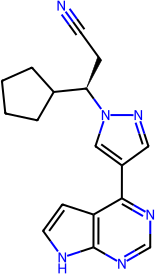
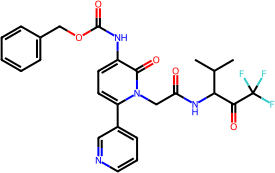
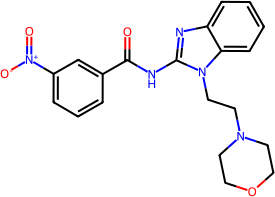
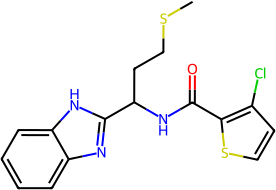
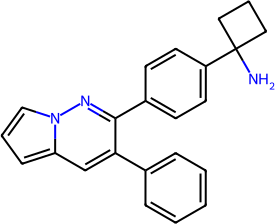
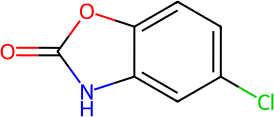
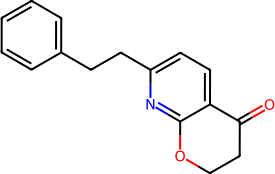
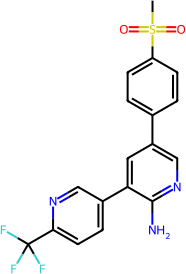
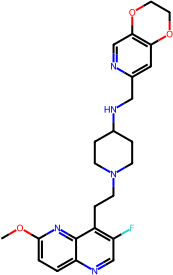
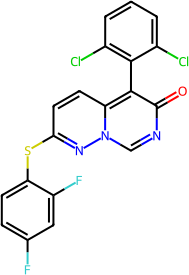
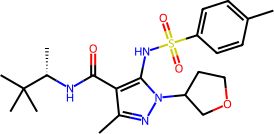
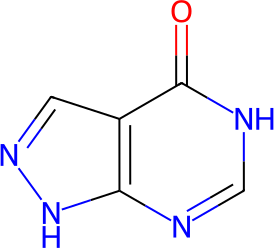
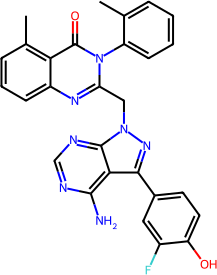
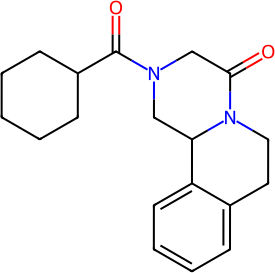
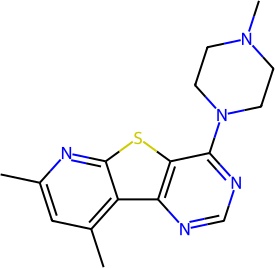
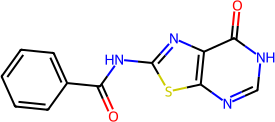
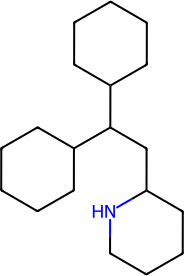
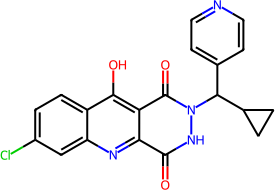
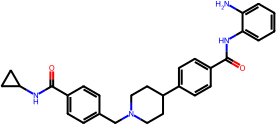
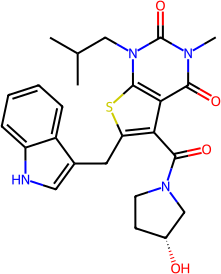
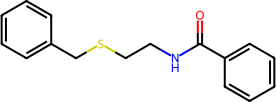
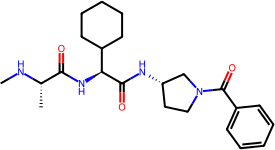
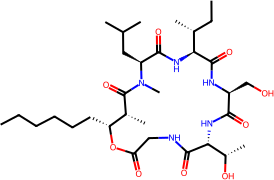
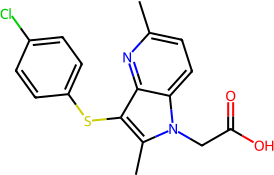
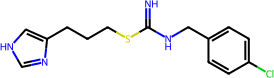
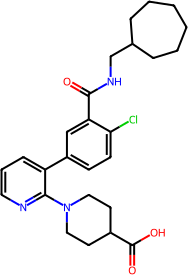
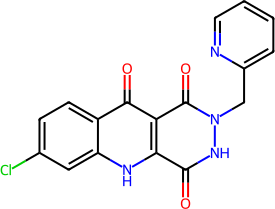
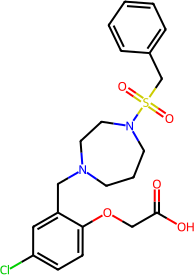
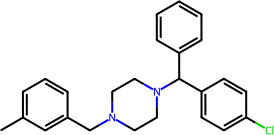
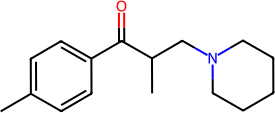
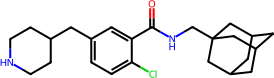
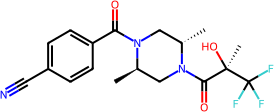
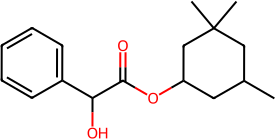
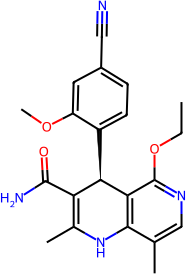
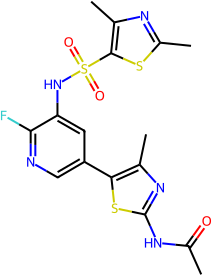
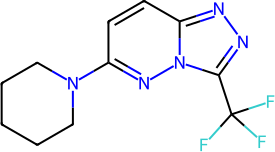
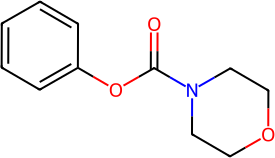
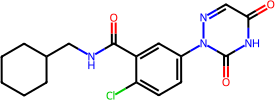
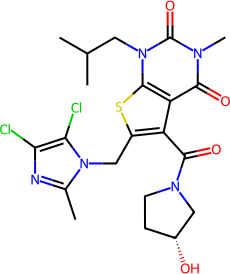
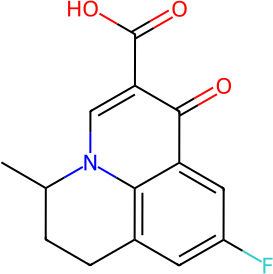
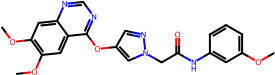
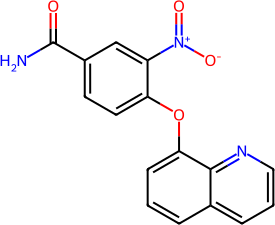
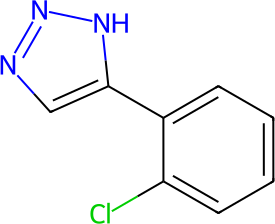
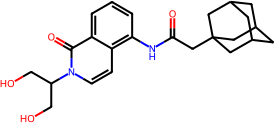
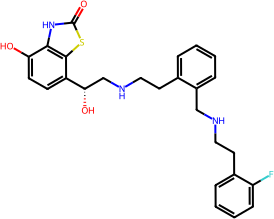
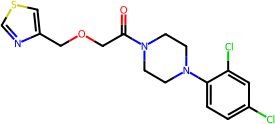
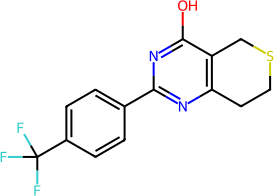
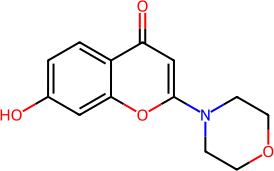
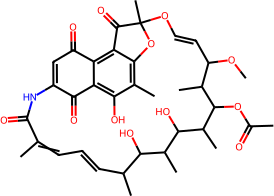
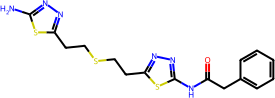
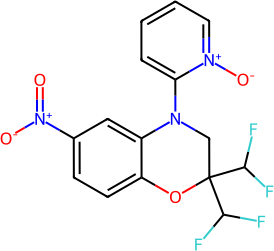
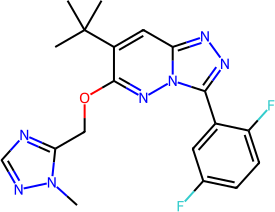
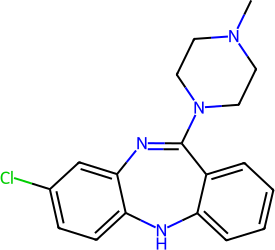
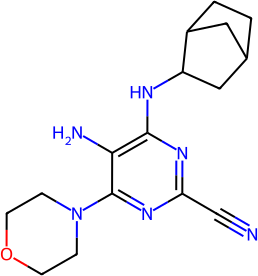
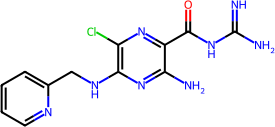
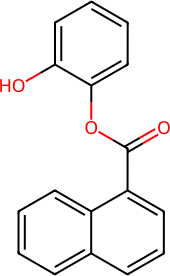
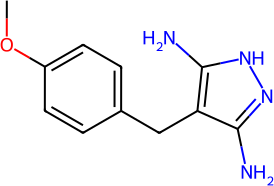
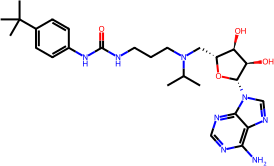
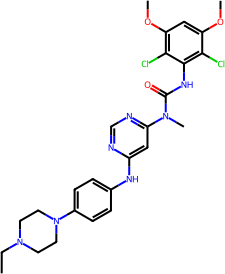
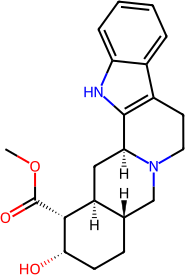
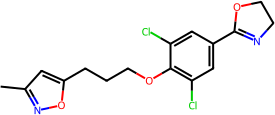
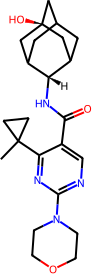
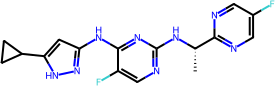
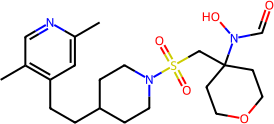
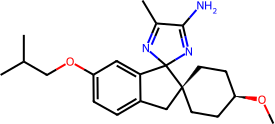
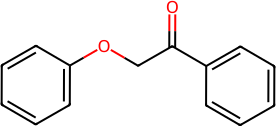
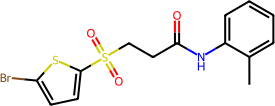
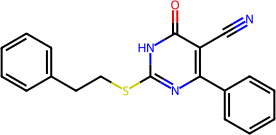
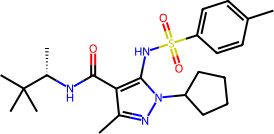
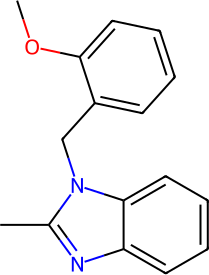
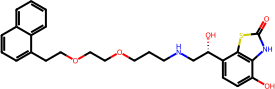
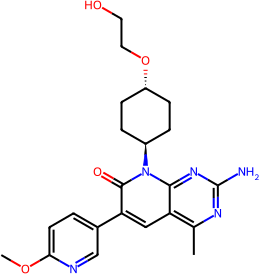
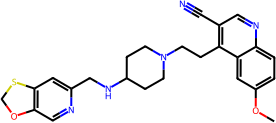
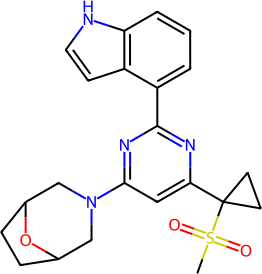
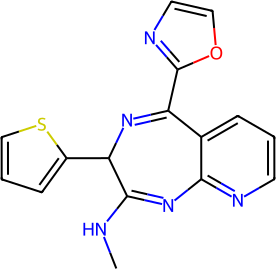
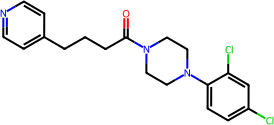
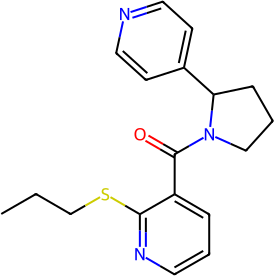

In [119]:
cpds = mf.MolFrame(df)
cpds = cpds.add_b64()
hv.extension('bokeh')
cpds.scatter("measured", "predicted")

Let's plot the train data set to visually compare those two sets. We made the markers (points) smaller because there are so many and we don't want them to overlap with each other so much.

In [120]:
lipos_train = model.predict_on_batch(train_dataset.X)
lipo_list_train = []
expt_lipo_list_train = []
for molecule, lipo, test_lipo in zip(train_dataset.ids, lipos_train, train_dataset.y):
    lipo_list_train += [lipo[0]]
    expt_lipo_list_train += [test_lipo[0]]
df_train = pd.DataFrame(list(zip(expt_lipo_list_train, lipo_list_train)), columns = ["measured", "predicted"])
seaborn.scatterplot(data=df_train, x = "measured", y = "predicted", s=5, palette=["orange"]).set(title='Lipophilicty for train data:\noctanol/water distribution coefficient\n(logD at pH 7.4)\n');
plt.plot(equal_line_x, equal_line_y, color='k', linewidth=0.5);

(Unfortunately, mol_frame takes too long to render thousands of molecules so that Google Colab disconnects before it completes. So we're not showing the interactive plot here. You probably could if you ran this notebook locally.)

To overlay the two plots, we'll first [concatenate the data](https://stackoverflow.com/questions/51732867/seaborn-plot-two-data-sets-on-the-same-scatter-plot#51733133) in the two sets (test and train), adding a `dataset` column to keep track of which set each point came from.

In [121]:
# Remove the columns we added to the test dataframe for mol_frame
try:
  df.drop(columns=["Smiles", "Compound_Id"], inplace=True)
except:
  # Suppress any error if those columns have already been dropped
  pass

concatenated = pd.concat([df.assign(dataset='test'), df_train.assign(dataset='train')])
concatenated

measured  predicted dataset
0    -1.810832  -0.733463    test
1     0.319651  -0.555725    test
2    -0.192325   0.204472    test
3     0.938978   0.708903    test
4     0.856401   0.135500    test
...        ...        ...     ...
3355  0.526093  -0.257278   train
3356 -0.027172  -0.006421   train
3357 -1.629163  -1.675025   train
3358  0.633443   0.797771   train
3359 -0.960290  -1.626846   train

[3780 rows x 3 columns]

Now we can plot the two datasets on one graph.

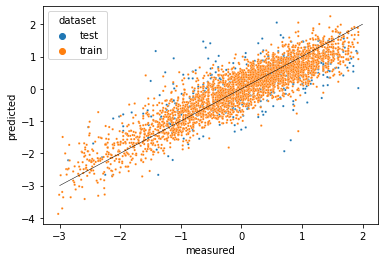

In [122]:
seaborn.scatterplot(x='measured', 
                    y='predicted', 
                    data=concatenated,
                    hue='dataset',
                    s=5);
plt.plot(equal_line_x, equal_line_y, color='k', linewidth=0.5);

Some of the test (blue) data points are predicted (on the vertical axis) outliers, reflecting that the model performs poorly for them. We might consider featurizing our data further to let the model predict lipophilicity based on more properties of the compounds. Above, we used the [`GraphConv`](https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html#graph-convolution-featurizers) featurizer, which represents only the atoms in a molecule. We might try the [`WeaveFeaturizer`](https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html#weavefeaturizer) which also represents the bonds, though it requires more resources because it stores the relationship between each pair of atoms in a molecule.

This blog post was based on the DeepChem tutorial [The Basic Tools of the Deep Life Sciences](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/The_Basic_Tools_of_the_Deep_Life_Sciences.ipynb).